In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.6.3


In [2]:
# Create a list with the filepaths for training and testing
# Remeber to adjust this to your Pc path and make sure you`ve downloaded the dataset
train_dir = Path('../Fruit_Vegetable_Recognition/Dataset/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [3]:
test_dir = Path('../Fruit_Vegetable_Recognition/Dataset/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [4]:
val_dir = Path('../Fruit_Vegetable_Recognition/Dataset/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [5]:
def image_processing(filepath):
     # Create a DataFrame with the filepath and the labels of the pictures

    # You you probably need to adapt this split method to your Pc path, mine was using this double bars
    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [6]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)


In [7]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['lemon' 'raddish' 'beetroot' 'watermelon' 'jalepeno' 'paprika' 'capsicum'
 'carrot' 'orange' 'pomegranate' 'peas' 'cucumber' 'onion' 'spinach'
 'sweetcorn' 'chilli pepper' 'tomato' 'garlic' 'ginger' 'pineapple'
 'bell pepper' 'cauliflower' 'kiwi' 'sweetpotato' 'soy beans' 'corn'
 'apple' 'potato' 'cabbage' 'lettuce' 'banana' 'grapes' 'eggplant' 'mango'
 'turnip' 'pear']


In [8]:
train_df.head(5)

,Filepath,Label
0,..\Fruit_Vegetable_Recognition\Dataset\train\l...,lemon
1,..\Fruit_Vegetable_Recognition\Dataset\train\r...,raddish
2,..\Fruit_Vegetable_Recognition\Dataset\train\b...,beetroot
3,..\Fruit_Vegetable_Recognition\Dataset\train\w...,watermelon
4,..\Fruit_Vegetable_Recognition\Dataset\train\j...,jalepeno


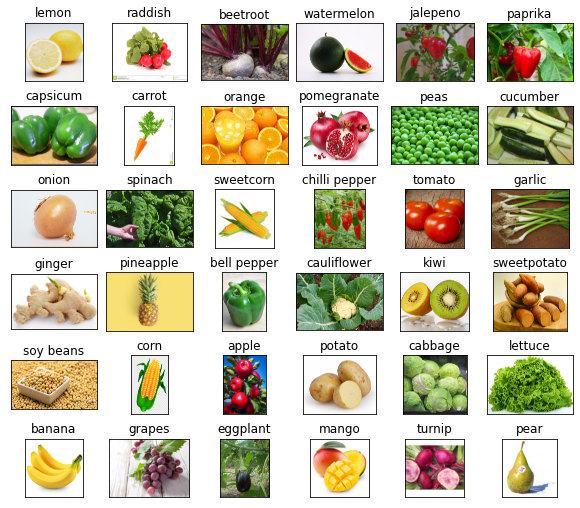

In [9]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [22]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2855 validated image filenames belonging to 36 classes.


In [12]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 340 validated image filenames belonging to 36 classes.


In [13]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 340 validated image filenames belonging to 36 classes.


In [14]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [15]:
# Training the model take some minutes, so if you don't want to run this cell its ok, the trained model for vegetables and fruits is already saved in the project root(FV.h5)
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
90/90 [==============================] - 148s 2s/step - loss: 1.7450 - accuracy: 0.5447 - val_loss: 0.4404 - val_accuracy: 0.8647
Epoch 2/5
90/90 [==============================] - 123s 1s/step - loss: 0.5646 - accuracy: 0.8280 - val_loss: 0.2869 - val_accuracy: 0.9000
Epoch 3/5
90/90 [==============================] - 131s 1s/step - loss: 0.3526 - accuracy: 0.8876 - val_loss: 0.2480 - val_accuracy: 0.9265
Epoch 4/5
90/90 [==============================] - 111s 1s/step - loss: 0.2321 - accuracy: 0.9254 - val_loss: 0.2006 - val_accuracy: 0.9500
Epoch 5/5
90/90 [==============================] - 109s 1s/step - loss: 0.1622 - accuracy: 0.9510 - val_loss: 0.2127 - val_accuracy: 0.9441


In [23]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

['pineapple',
 'cabbage',
 'pineapple',
 'turnip',
 'cabbage',
 'beetroot',
 'ginger',
 'carrot',
 'potato',
 'pineapple',
 'orange',
 'kiwi',
 'sweetcorn',
 'banana',
 'sweetcorn',
 'pear',
 'sweetpotato',
 'potato',
 'eggplant',
 'apple',
 'mango',
 'orange',
 'beetroot',
 'grapes',
 'raddish',
 'cucumber',
 'pomegranate',
 'eggplant',
 'bell pepper',
 'sweetcorn',
 'raddish',
 'sweetpotato',
 'raddish',
 'apple',
 'lettuce',
 'cauliflower',
 'chilli pepper',
 'spinach',
 'corn',
 'banana',
 'kiwi',
 'garlic',
 'beetroot',
 'jalepeno',
 'kiwi',
 'sweetcorn',
 'bell pepper',
 'turnip',
 'pineapple',
 'carrot',
 'potato',
 'bell pepper',
 'onion',
 'chilli pepper',
 'beetroot',
 'sweetcorn',
 'orange',
 'banana',
 'apple',
 'peas',
 'paprika',
 'eggplant',
 'orange',
 'garlic',
 'paprika',
 'bell pepper',
 'raddish',
 'tomato',
 'pomegranate',
 'capsicum',
 'capsicum',
 'chilli pepper',
 'potato',
 'pineapple',
 'watermelon',
 'apple',
 'bell pepper',
 'sweetpotato',
 'jalepeno',
 'bel

In [24]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [20]:
img = output('../Fruit_Vegetable_Recognition/Dataset/train/cabbage/Image_1.jpg')
img

'cabbage'

In [21]:
model.save('FV.h5')

c:\users\bruno\pycharmprojects\fruit_vegetable_recognition\venv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
